# SoundMap Music Recommendation (Based on CNN Classification)

## II. Music Genre Classification Using ResNet-Based CNN

#### Project **SoundMap** ([Github](https://github.com/hojungcho/SoundMap))
Audio Analysis & AI Modeling - Jeeho Lim

## Overview
This notebook demonstrates the implementation of a convolutional neural network (CNN) based on the ResNet architecture for classifying music genres. The model uses spectrogram images of audio as input and is trained using PyTorch. Early stopping and learning rate adjustments are applied to optimize training. We will walk through each step, from data loading and preprocessing to model training and evaluation.

### Requirements

- Python==3.11.5
- pandas==2.0.3 
- numpy==1.24.3 
- librosa==0.10.2.post1 
- matplotlib==3.7.2
- Pillow (PIL)==9.4.0 
- scikit-learn==1.3.0

## Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
from tqdm import tqdm
import time
import copy
import matplotlib.pyplot as plt

## Dataset Preparation

Load the pre-saved training data using the `train_x.npy` and `train_y.npy` files. These files contain the **image data** and **labels** necessary for training.

The dataset is split into **training** and **validation** sets in an 80:20 ratio. This split allows us to **evaluate performance** during training using the validation set.

In [4]:
# Dataset class
class MusicDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx].astype(np.float32) / 255.0, self.labels[idx]

In [5]:
# Load data
train_x = np.load('Training_Data/train_x.npy')
train_y = np.load('Training_Data/train_y.npy')

In [6]:
# Create dataset and split
dataset = MusicDataset(train_x, train_y)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [7]:
# DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Model Architecture: ResNet-Based CNN
The model is a custom implementation of a CNN inspired by the ResNet architecture. It utilizes convolutional layers with residual blocks and batch normalization to ensure stability during training. Below is the code for defining the convolutional layers and the complete model architecture.


To construct a ResNet-based network, we define Conv2D layers and Residual Blocks:

- **`conv`**: A function that creates a convolutional layer. It uses a **kernel size** of 3, **stride** of 1, and padding to maintain the spatial dimensions of the input.
- **`conv_layer`**: This layer adds **Batch Normalization** and a **ReLU activation** function to the convolutional layer, enhancing the network’s learning capability.
- **`ResBlock`**: Implements a **Residual Block**, which passes the input through two convolutional layers and adds the original input back, maintaining a **residual connection**. This structure helps **stabilize training**, especially as the network deepens.
- **`conv_layer_averpl`**: Combines a convolutional layer with **average pooling** to reduce the resolution of the input image, effectively reducing the feature map size.

These blocks are designed to facilitate **efficient training**, even as the network depth increases.

In [3]:
# Define the conv layer and ResBlock
def conv(ni, nf, ks=3, stride=1, bias=False):
    return nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2, bias=bias)

def conv_layer(ni, nf, ks=3, stride=1, act=True):
    bn = nn.BatchNorm2d(nf)
    layers = [conv(ni, nf, ks, stride)]
    if act:
        layers.append(nn.ReLU(inplace=True))
    layers.append(bn)
    return nn.Sequential(*layers)

class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf, nf)
        self.conv2 = conv_layer(nf, nf, act=False)

    def forward(self, x):
        return x + self.conv2(self.conv1(x))

def conv_layer_averpl(ni, nf):
    return nn.Sequential(conv_layer(ni, nf), nn.AvgPool2d(2, 2))

# Define the complete CNN model
class MusicGenreCNN(nn.Module):
    def __init__(self):
        super(MusicGenreCNN, self).__init__()
        self.model = nn.Sequential(
            conv_layer_averpl(1, 64),
            ResBlock(64),
            conv_layer_averpl(64, 64),
            ResBlock(64),
            conv_layer_averpl(64, 128),
            ResBlock(128),
            conv_layer_averpl(128, 256),
            ResBlock(256),
            conv_layer_averpl(256, 512),
            ResBlock(512),
            nn.AdaptiveAvgPool2d((2, 2)),
            nn.Flatten(),
            nn.Linear(2048, 40),
            nn.Linear(40, 8)
        )

    def forward(self, x):
        return self.model(x)

Set up the **loss function** (`CrossEntropyLoss`) and the **optimizer** (`AdamW`). These components are critical for **model optimization** and learning.

In [8]:
# Model setup
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = MusicGenreCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)

## Training Configuration
We configure the loss function, optimizer, and learning rate adjustment function. We also implement early stopping to halt training if the validation loss does not improve after several epochs.


A function is defined to **calculate accuracy** by comparing the model’s predictions with the actual labels. This helps monitor the model’s **performance** during training.

In [9]:
# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels).item()

Provide a function to **adjust the learning rate** at each epoch. The base learning rate is reduced by a factor of 10 every specified number of epochs (`decay_epoch`) to help **prevent overfitting** as training progresses.

In [10]:
# Learning rate adjustment
def adjust_learning_rate(optimizer, epoch, learning_rate, decay_epoch=12):
    lr = learning_rate * (0.1 ** (epoch // decay_epoch))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr


## Model Training
We train the model for a maximum of 50 epochs while adjusting the learning rate and checking for early stopping. Training and validation accuracy/loss are tracked and stored for visualization.


In [11]:
# Early Stopping criteria
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.1):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss * (1 + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [12]:
# Initialize history dictionary to store loss and accuracy
hist = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

# Initialize early stopping and other tracking variables
early_stopping = EarlyStopping(patience=5, min_delta=0.1)
best_model_wts = copy.deepcopy(model.state_dict())

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Adjust learning rate
    lr = adjust_learning_rate(optimizer, epoch, 0.0001)
    print(f"Epoch {epoch+1}/{epochs} - Learning Rate: {lr}")

    start_time = time.time()
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as pbar:
        for i, (images, labels) in enumerate(train_loader):
            images = images.unsqueeze(1).to(device)
            labels = labels.squeeze().long().to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct_train += calculate_accuracy(outputs, labels)
            total_train += labels.size(0)

            pbar.set_postfix({"Loss": running_loss / (i + 1), "Acc": 100 * correct_train / total_train})
            pbar.update(1)

    train_accuracy = 100 * correct_train / total_train
    elapsed_time = time.time() - start_time
    print(f"Epoch [{epoch+1}/{epochs}] completed in {elapsed_time:.2f} seconds. Loss: {running_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")

    # Save train loss and accuracy
    hist['train_loss'].append(running_loss / len(train_loader))
    hist['train_acc'].append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.unsqueeze(1).to(device)
            labels = labels.squeeze().long().to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            correct_val += calculate_accuracy(outputs, labels)
            total_val += labels.size(0)

    val_accuracy = 100 * correct_val / total_val
    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Save validation loss and accuracy
    hist['val_loss'].append(avg_val_loss)
    hist['val_acc'].append(val_accuracy)

    # Check early stopping criteria
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping at Epoch {epoch+1}")
        break

    # Save the best model if the current validation loss is the lowest
    if early_stopping.best_loss is None or avg_val_loss <= early_stopping.best_loss:
        best_model_wts = copy.deepcopy(model.state_dict())
        print(f"Best model updated at Epoch {epoch+1} with Validation Accuracy: {val_accuracy:.2f}% and Loss: {avg_val_loss:.4f}")

# Load the best model weights
model.load_state_dict(best_model_wts)

# Save the best model
torch.save(model.state_dict(), 'best_model.pt')

Epoch 1/50 - Learning Rate: 0.0001


Epoch 1/50: 100%|███| 1328/1328 [03:31<00:00,  6.29batch/s, Loss=1.46, Acc=48.3]


Epoch [1/50] completed in 211.20 seconds. Loss: 1.4559, Train Accuracy: 48.28%
Validation Loss: 1.3974, Validation Accuracy: 51.38%
Best model updated at Epoch 1 with Validation Accuracy: 51.38% and Loss: 1.3974
Epoch 2/50 - Learning Rate: 0.0001


Epoch 2/50: 100%|███| 1328/1328 [03:39<00:00,  6.06batch/s, Loss=1.25, Acc=56.4]


Epoch [2/50] completed in 219.12 seconds. Loss: 1.2546, Train Accuracy: 56.36%
Validation Loss: 1.2177, Validation Accuracy: 57.91%
Best model updated at Epoch 2 with Validation Accuracy: 57.91% and Loss: 1.2177
Epoch 3/50 - Learning Rate: 0.0001


Epoch 3/50: 100%|███| 1328/1328 [03:43<00:00,  5.94batch/s, Loss=1.16, Acc=59.8]


Epoch [3/50] completed in 223.62 seconds. Loss: 1.1552, Train Accuracy: 59.80%
Validation Loss: 1.1824, Validation Accuracy: 58.82%
Best model updated at Epoch 3 with Validation Accuracy: 58.82% and Loss: 1.1824
Epoch 4/50 - Learning Rate: 0.0001


Epoch 4/50: 100%|█████| 1328/1328 [03:38<00:00,  6.07batch/s, Loss=1.07, Acc=63]


Epoch [4/50] completed in 218.73 seconds. Loss: 1.0694, Train Accuracy: 63.01%
Validation Loss: 1.0925, Validation Accuracy: 61.83%
Best model updated at Epoch 4 with Validation Accuracy: 61.83% and Loss: 1.0925
Epoch 5/50 - Learning Rate: 0.0001


Epoch 5/50: 100%|██| 1328/1328 [03:38<00:00,  6.09batch/s, Loss=0.974, Acc=66.2]


Epoch [5/50] completed in 218.20 seconds. Loss: 0.9744, Train Accuracy: 66.23%
Validation Loss: 1.1029, Validation Accuracy: 61.59%
Best model updated at Epoch 5 with Validation Accuracy: 61.59% and Loss: 1.1029
Epoch 6/50 - Learning Rate: 0.0001


Epoch 6/50: 100%|██| 1328/1328 [03:38<00:00,  6.07batch/s, Loss=0.857, Acc=70.3]


Epoch [6/50] completed in 218.96 seconds. Loss: 0.8567, Train Accuracy: 70.31%
Validation Loss: 0.9664, Validation Accuracy: 66.67%
Best model updated at Epoch 6 with Validation Accuracy: 66.67% and Loss: 0.9664
Epoch 7/50 - Learning Rate: 0.0001


Epoch 7/50: 100%|████| 1328/1328 [03:36<00:00,  6.13batch/s, Loss=0.722, Acc=75]


Epoch [7/50] completed in 216.75 seconds. Loss: 0.7225, Train Accuracy: 75.03%
Validation Loss: 0.9282, Validation Accuracy: 68.77%
Best model updated at Epoch 7 with Validation Accuracy: 68.77% and Loss: 0.9282
Epoch 8/50 - Learning Rate: 0.0001


Epoch 8/50: 100%|██| 1328/1328 [03:38<00:00,  6.07batch/s, Loss=0.589, Acc=79.6]


Epoch [8/50] completed in 218.96 seconds. Loss: 0.5890, Train Accuracy: 79.58%
Validation Loss: 0.8645, Validation Accuracy: 71.49%
Best model updated at Epoch 8 with Validation Accuracy: 71.49% and Loss: 0.8645
Epoch 9/50 - Learning Rate: 0.0001


Epoch 9/50: 100%|████| 1328/1328 [03:34<00:00,  6.18batch/s, Loss=0.461, Acc=84]


Epoch [9/50] completed in 214.99 seconds. Loss: 0.4614, Train Accuracy: 83.95%
Validation Loss: 0.8601, Validation Accuracy: 73.25%
Best model updated at Epoch 9 with Validation Accuracy: 73.25% and Loss: 0.8601
Epoch 10/50 - Learning Rate: 0.0001


Epoch 10/50: 100%|██| 1328/1328 [03:39<00:00,  6.06batch/s, Loss=0.35, Acc=87.9]


Epoch [10/50] completed in 219.10 seconds. Loss: 0.3499, Train Accuracy: 87.90%
Validation Loss: 0.8004, Validation Accuracy: 75.83%
Best model updated at Epoch 10 with Validation Accuracy: 75.83% and Loss: 0.8004
Epoch 11/50 - Learning Rate: 0.0001


Epoch 11/50: 100%|█| 1328/1328 [03:39<00:00,  6.06batch/s, Loss=0.267, Acc=90.7]


Epoch [11/50] completed in 219.07 seconds. Loss: 0.2674, Train Accuracy: 90.65%
Validation Loss: 0.8889, Validation Accuracy: 74.82%
Epoch 12/50 - Learning Rate: 0.0001


Epoch 12/50: 100%|██| 1328/1328 [03:36<00:00,  6.13batch/s, Loss=0.22, Acc=92.4]


Epoch [12/50] completed in 216.66 seconds. Loss: 0.2200, Train Accuracy: 92.36%
Validation Loss: 0.9294, Validation Accuracy: 74.97%
Epoch 13/50 - Learning Rate: 1e-05


Epoch 13/50: 100%|█| 1328/1328 [03:38<00:00,  6.08batch/s, Loss=0.0636, Acc=98.1


Epoch [13/50] completed in 218.49 seconds. Loss: 0.0636, Train Accuracy: 98.14%
Validation Loss: 0.7509, Validation Accuracy: 81.09%
Best model updated at Epoch 13 with Validation Accuracy: 81.09% and Loss: 0.7509
Epoch 14/50 - Learning Rate: 1e-05


Epoch 14/50: 100%|█| 1328/1328 [03:39<00:00,  6.06batch/s, Loss=0.0221, Acc=99.5


Epoch [14/50] completed in 219.02 seconds. Loss: 0.0221, Train Accuracy: 99.52%
Validation Loss: 0.8324, Validation Accuracy: 81.60%
Epoch 15/50 - Learning Rate: 1e-05


Epoch 15/50: 100%|█| 1328/1328 [03:39<00:00,  6.05batch/s, Loss=0.014, Acc=99.7]


Epoch [15/50] completed in 219.44 seconds. Loss: 0.0140, Train Accuracy: 99.70%
Validation Loss: 0.8930, Validation Accuracy: 81.54%
Epoch 16/50 - Learning Rate: 1e-05


Epoch 16/50: 100%|█| 1328/1328 [03:38<00:00,  6.09batch/s, Loss=0.0102, Acc=99.8


Epoch [16/50] completed in 218.06 seconds. Loss: 0.0102, Train Accuracy: 99.79%
Validation Loss: 0.9365, Validation Accuracy: 81.73%
Epoch 17/50 - Learning Rate: 1e-05


Epoch 17/50: 100%|█| 1328/1328 [03:40<00:00,  6.03batch/s, Loss=0.0102, Acc=99.8


Epoch [17/50] completed in 220.35 seconds. Loss: 0.0102, Train Accuracy: 99.79%
Validation Loss: 0.9801, Validation Accuracy: 81.58%
Epoch 18/50 - Learning Rate: 1e-05


Epoch 18/50: 100%|█| 1328/1328 [03:39<00:00,  6.06batch/s, Loss=0.00764, Acc=99.


Epoch [18/50] completed in 219.08 seconds. Loss: 0.0076, Train Accuracy: 99.81%
Validation Loss: 1.0127, Validation Accuracy: 81.78%
Early stopping at Epoch 18


## Training and Validation History
We visualize the training and validation loss and accuracy over the epochs to analyze the model's performance and check for any signs of overfitting.


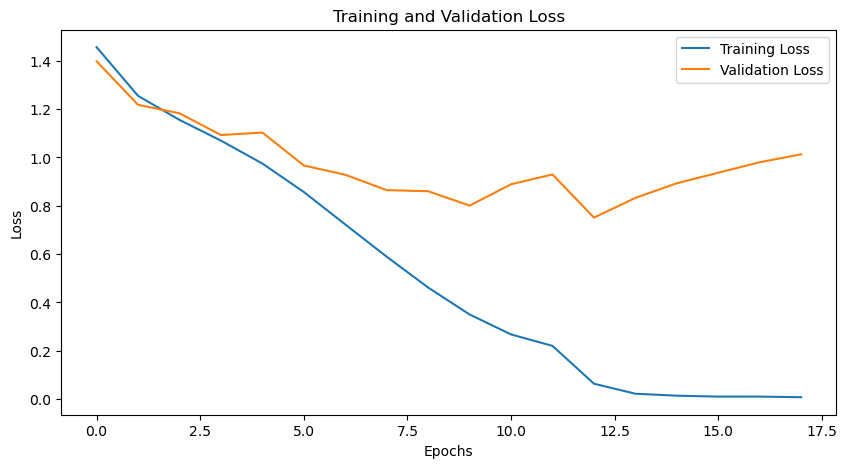

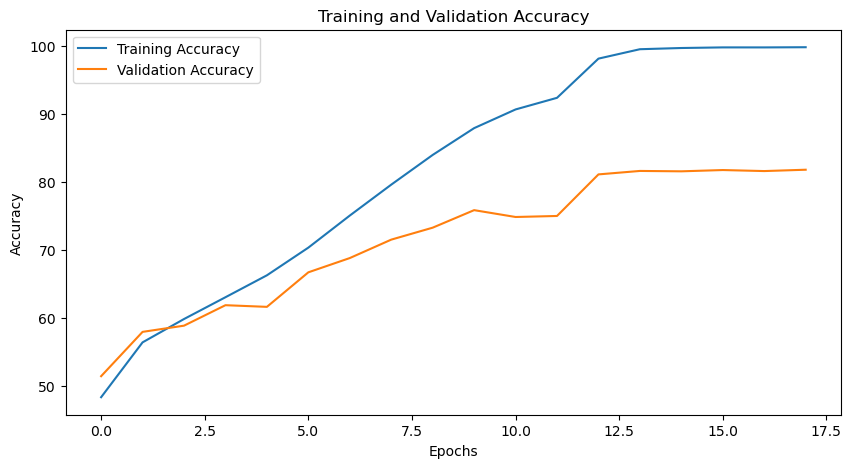

In [13]:
# Plotting training and validation history
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(hist['train_loss'], label='Training Loss')
plt.plot(hist['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(hist['train_acc'], label='Training Accuracy')
plt.plot(hist['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

## Conclusion

The CNN model based on ResNet architecture was trained over **18 epochs** to classify music genres. During training, the model achieved a **training accuracy** of up to **99.81%**, demonstrating effective learning. Validation accuracy peaked at **81.78%**, indicating that the model was able to generalize well to unseen data. 

Early stopping was applied to prevent overfitting. The training was halted at **Epoch 18**, when the validation loss began to rise and exceeded the early stopping criteria. The lowest validation loss recorded was **0.7509** with a corresponding validation accuracy of **81.09%** at **Epoch 13**. 

Key observations from the training process:

- The model’s accuracy improved consistently as the learning rate was adjusted, highlighting the importance of **learning rate scheduling**.
- Early stopping proved effective in preventing **overfitting**, ensuring that the model performance on validation data was maintained without further unnecessary training.
- The training results show a strong fit with the training data; however, the validation accuracy suggests room for further tuning or using techniques such as **data augmentation** to enhance performance.

The final model, saved based on the best validation performance, shows promising results for future application in **music genre classification** based on audio features.


### Further Improvements
- **Data Augmentation**: Incorporating data augmentation techniques such as time-stretching or pitch-shifting could enhance model robustness.
- **Hyperparameter Tuning**: Experimenting with different learning rates, batch sizes, and ResNet block configurations could further optimize performance.
- **Transfer Learning**: Using pretrained models on similar audio tasks might accelerate convergence and improve accuracy.
